<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban
</font>
<br>
<br>
<font size=6>
Homework 2
</font><br>
<font size=4>


In the following notebook, we aims to develop a Convolutional Neural Network (CNN) using the PyTorch framework that can accurately detect and classify Brain Tumors from MRI scans. The CNN will be trained on a large dataset of labeled brain tumor images to learn the patterns and features associated with different tumor types.

## <b>1 <span style='color:#e61227'>|</span> reuirements and libraries</b>

Feel free to add any other library you need.


In [1]:
# !pip install split-folders
# !pip install torch-summary

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

## <b>2 <span style='color:#e61227'>|</span> Dataset</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>2.1 |</span></b> Download and load Dataset</b></p>
</div>

In [3]:
# ! gdown 1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh
# ! aiunzbrn.zipip 

## <b>3 <span style='color:#e61227'>|</span> Data Preparation </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>3.1 |</span></b> Splitting Dataset</b></p>
</div>

- We need to evaluate the model on validation datasets to track the model's performance during training. Then, We use 20% of the dataset for the **Validation set** and use the rest as the **Training set**, so we have an **80/20** split!

In [4]:
# Dataset Path
from pathlib import Path
# data_dir = '/content/brain'
data_dir = Path("c:/Users/amir mohammad/Desktop/rohban/IABI_HW2/brain")


In [5]:
# define transformation
# transform images to (256, 256) and normalize them
transform = transforms.Compose(
    [
    transforms.Resize(size=(256, 256), max_size=None, antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=[-30.0, 30.0], expand=False, fill=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
 

## <b>4 <span style='color:#e61227'>|</span> Image Augmentation Definitions</b>

In [6]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

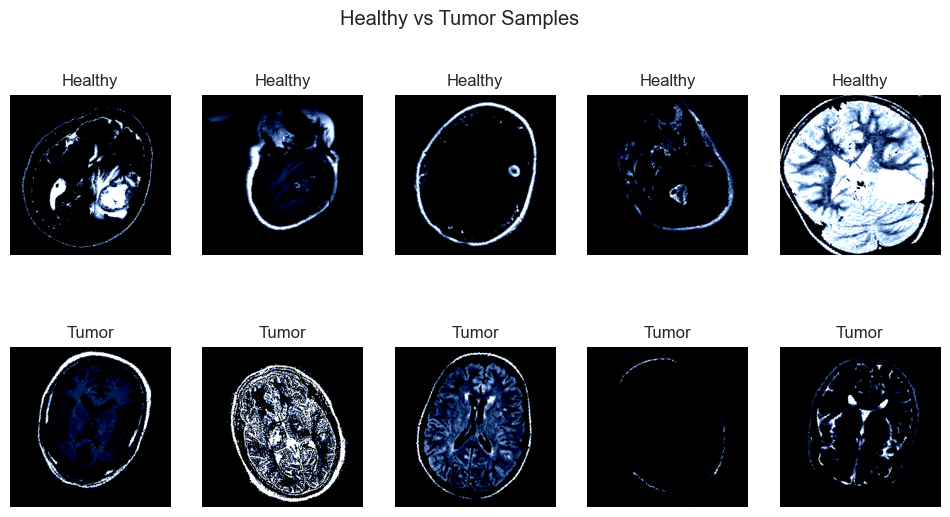

In [7]:
# Visualiztion some images from Train Set, half healthy and half tumor images
import random


healthy_indices = [i for i, (_, label) in enumerate(train_set) if label == train_set.class_to_idx['Brain Tumor']]
tumor_indices = [i for i, (_, label) in enumerate(train_set) if label == train_set.class_to_idx['Healthy']]

# Take a subset of healthy and tumor images for visualization
num_images = 5 # Number of images from each class to display
selected_healthy = random.sample(healthy_indices, num_images)
selected_tumor = random.sample(tumor_indices, num_images)

# Create a figure for displaying the images
fig, axes = plt.subplots(2, num_images, figsize=(12, 6))
fig.suptitle("Healthy vs Tumor Samples")

# Display healthy images in the first row
for i, idx in enumerate(selected_healthy):
    img, _ = train_set[idx]
    axes[0, i].imshow(img.permute(1, 2, 0))  # Convert to H x W x C
    axes[0, i].set_title("Healthy")
    axes[0, i].axis("off")

# Display tumor images in the second row
for i, idx in enumerate(selected_tumor):
    img, _ = train_set[idx]
    axes[1, i].imshow(img.permute(1, 2, 0))  # Convert to H x W x C
    axes[1, i].set_title("Tumor")
    axes[1, i].axis("off")

plt.show()

## <b>5 <span style='color:#e61227'>|</span> Creating Dataloaders</b>

In [8]:
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [9]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



## <b>6 <span style='color:#e61227'>|</span> Define Brain Tumor Classifier</b>


In [10]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters. You may not use it in your code'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [11]:
# Define any arbitrary Architecture For CNN_TUMOR Model

class CNN_TUMOR(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        ########################################
                  ### TODO ###
        # define layers of the model here
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        

        ########################################

    def forward(self,X):
        ########################################
                # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)
        ########################################

In [12]:
# define parameters of the model
params_model={
        "shape_in":(3,256,256) ,
        "initial_filters": 8 ,
        "num_fc1": 100 ,
        "dropout_rate": 0.25 ,
        "num_classes": 2 }

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

## <b>7 <span style='color:#e61227'>|</span> Loss Function Definition</b>

In [13]:
# define the loss function

loss_func = nn.NLLLoss(reduction="sum")

## <b>8 <span style='color:#e61227'>|</span> Optimiser Definition</b>

In [14]:
# define the optimizer
opt = optim.Adam(cnn_model.parameters() , lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>9 <span style='color:#e61227'>|</span> Training Model</b>

In [18]:
# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target):

    ########################################
    loss = loss_func (output , target )
    pred = output.argmax(dim=1 , keepdim=True )
    metric_b = pred.eq(target.view_as(pred)).sum().item()

    ########################################

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt):

    run_loss=0.0
    accuracy_t=0.0
    accuracy=0.0
    len_data=len(dataset_dl.dataset)
    # internal loop over dataset
    ########################################
    for x , y in dataset_dl:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss_b , accuracy_b = loss_batch(loss_func, output, y) 
        run_loss += loss_b 
        accuracy_t += accuracy_b  
    loss = run_loss/float(len_data)
    accuracy = accuracy_t/float(len_data)
    ########################################
    return loss, accuracy

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.2 |</span></b> Training Function</b></p>
</div>


In [19]:
def Train_Val(model, train_dl, val_dl, epochs, opt, lr_scheduler, loss_func):

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in range(epochs):

        ########################################
                # Get the Learning Rate
        

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            # torch.save(model.state_dict(), weight_path)
                # print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        # lr_scheduler.step(val_loss)
        # if current_lr != get_lr(opt):

        #     print("Loading best model weights!")
        #     model.load_state_dict(best_model_wts) 

        
        #     print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
        #     print("-"*10) 
        




        # train the model for n epoch. report loss value and accuracy of the model for train and val datasets
        # in each epoch, save the weights of the best model
        ########################################

        print(f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
        print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.3 |</span></b> Training Process </b></p>
</div>

In [21]:
# Define parameters used for training and evaluation of a cnn_model
epochs = 20

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model, train_loader, val_loader, epochs, opt, lr_scheduler, loss_func)

OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 2.00 GiB of which 0 bytes is free. Of the allocated memory 1.07 GiB is allocated by PyTorch, and 55.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## <b>10 <span style='color:#e61227'>|</span> Evaluation Metric Visualization </b>

<Axes: >

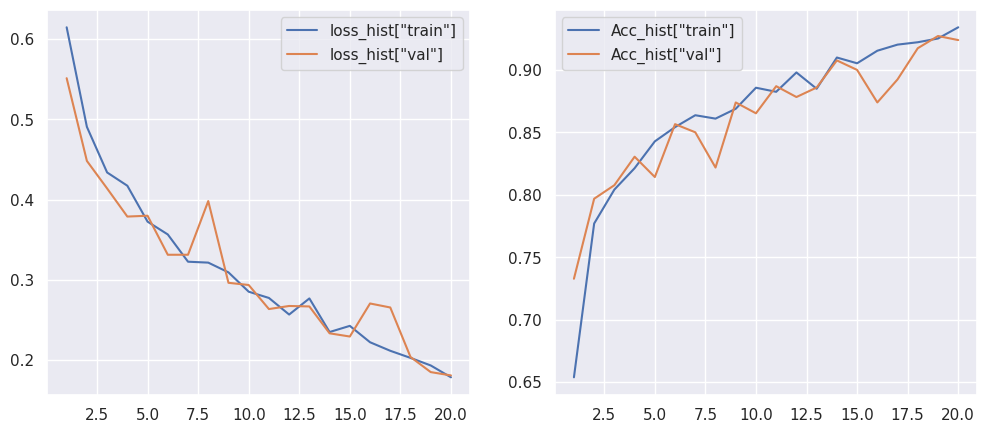

In [ ]:
# Convergence History Plot
# plot the loss vlues and accuracy of your model during the training process
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>10.2 |</span></b> Confusion_Matrix </b></p>
</div>

In [ ]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []

    ########################################
               ### TODO ###
    # calculate prediction and the ground truth for the val dataset.
    ########################################

    return y_true, y_pred


def confusion_matrix(y_true, y_pred)

    ########################################
               ### TODO ###
    # calculate confusion matrix
    ########################################

    return cm

# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       503
         1.0       0.86      0.89      0.87       418

    accuracy                           0.88       921
   macro avg       0.88      0.88      0.88       921
weighted avg       0.88      0.88      0.88       921
 




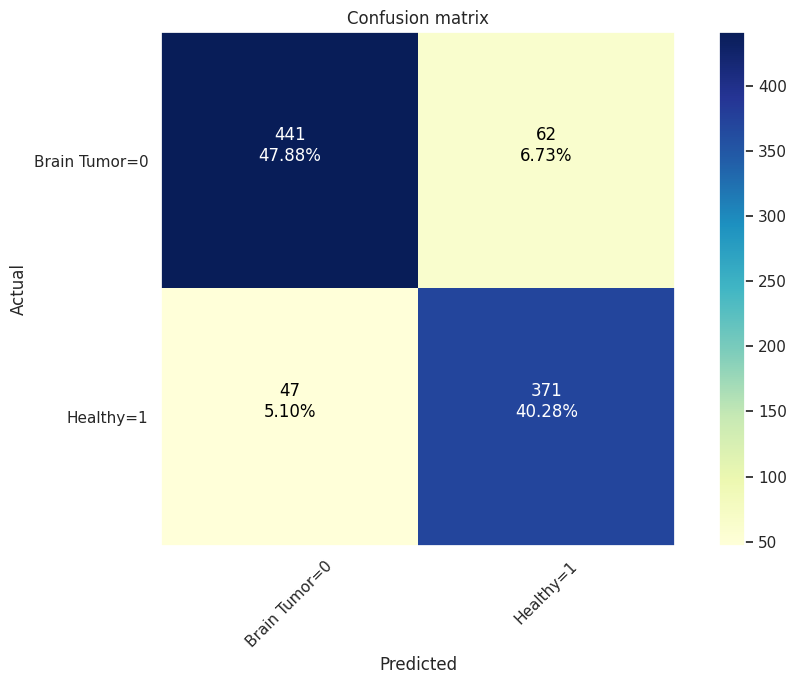

In [ ]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    ########################################
               ### TODO ###
    # visualize the confusion matrix
    ########################################

show_confusion_matrix(cm)